Введение

Вас перевели в отдел инновационной разработки рекомендательных систем. Ваш работадель хочет увеличить средний чек продаж. После короткого изучения статей вы поняли, что ключом к успеху будет качественные рекомендации на сайте. Чем лучше вы сможете рекомендовать товар пользователю, тем чаще он будет добавлять товары в корзину. Простая логика, если пользователю нравится товар, он его добавляет в корзину -> средний чек растёт. Мы нашли золото!

Датасет

У вас будет история оценок пользователя вместе с его обзором. Вы можете использовать текст рецензии в качестве дополнительной информации. Все оценки пользователей нормированы для бинарной классификации, если человек поставил оценку продукту больше 3 (не включительно), то мы считаем, что продукт ему понравился, если меньше 4, то продукт не понравился.

Метрики

В качестве метрики для оценки ваших рекомендаций используется RocAuc.

Условия соревнования

Данное соревнование является бессрочным и доступно для всех потоков.
Срок выполнения соревнования устанавливаеться индивидуально в каждом потоке.
Тестовая выборка представлена в ЛидерБорде целиком, поэтому лучшие и победные решения буду проверяться на их "адекватность" (чтоб не было подгонки под тестовую выборку).
В данном соревновании вам ненужны дополнительные внешние данные. Запрещается их использовать
Разрешено использовать любые ML алгоритмы и библиотеки.

-test.csv - набор данных, для которого вы должны сделать предсказания. У каждого наобора userid, itemid есть свой id, для которого вы должны сделать предсказание.

- overall - рейтинг, который поставил пользователь
- verified - был ли отзыв верифицирован
- reviewTime - когда был отзыв написан
- reviewerName - имя пользователя
- reviewText - текст отзыва
- summary - сжатый отзыв
- vote - количество голосований за отзыв
- style - метаданные
- image - изображение продукта
- userid - id пользователя
- itemid - id товара
- id - id для предсказания

#### Импорт библиотек

In [163]:
import numpy as np
import pandas as pd
from collections import Counter
import json
import re
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Загружаем датасеты
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

# # Постройчно прочитаем json с метаданными и положим результат в датасет "meta"
# with open('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json') as f:
#     meta_list = []
#     for line in f.readlines():
#         meta_list.append(json.loads(line))
        
# meta = pd.DataFrame(meta_list)

# Удалим дубликаты из тренировочного датасета
train.drop_duplicates(inplace = True)

# # Объединим тренировочный датасет и данные из meta по идентификатору asin (Amazon Standard Identification Number)
# df_new_train = pd.merge(train, meta, on='asin')

/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [164]:
# df_new_train = pd.merge(train, meta, on='asin')
# df_new_test = pd.merge(test, meta, on='asin')

### Объявление базовых функций

In [165]:
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'LightFM')
    plt.title('ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
# Функция без гистограммы
def col_info(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))

# Функция с гистограммой
def col_info_hist(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))
    ys.hist()
    
def describe_collumns(df):
    list_of_names = list(df.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    temp_dict['тип'] = df.dtypes
    temp_dict['# пропусков(NaN)'] = df.isnull().sum().values 
    temp_dict['# уникальных'] = df.nunique().values
    
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)

    return

#  у участников найдена функция по сравнению дата сетов перед объединением. 
def check_df_before_merg(d_df1,d_df2,n_line):
    
    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['# уник_1'] = d_df1.nunique().values
    temp_dict[f'в  строке_1 ({n_line} позиц-я)'] =d_df1.loc[n_line].values
    temp_dict['тип_1'] = d_df1.dtypes
    temp_dict['имя признака_1'] = list_of_names1
    temp_df1 = pd.DataFrame.from_dict(temp_dict)
    
    
    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['имя признака_2'] = list_of_names2
    temp_dict2['тип_2'] = d_df2.dtypes
    temp_dict2[f'в  строке_2 ({n_line} позиц-я)'] =d_df2.loc[n_line].values
    temp_dict2['# уник_2'] = d_df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)
    
    temp_df = pd.concat([temp_df1,temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []
    temp_list5  = []

    for i in range(len(temp_df)):
        if str(temp_df3['тип_2'][i]) != str(temp_df3['тип_1'][i]):
            temp_list.append(temp_df3['имя признака_1'][i])
            temp_list2.append(temp_df3['имя признака_2'][i])
            temp_list3.append(str(temp_df3['тип_1'][i]) + '!=' + str(temp_df3['тип_2'][i]))
            temp_list4.append(i)
        if temp_df3['# уник_2'][i]>0 and temp_df3['# уник_1'][i]/temp_df3['# уник_2'][i] > 2:
            temp_list5.append(i)
            
    temp_dict3['index']= temp_list4
    temp_dict3['имя признака_1']= temp_list
    temp_dict3['не совпадают типы'] = temp_list3
    temp_dict3['имя признака_2']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'Резюме:\n 1. Не совпали типы в:= {len(temp_df4)} столбцах\n')
    print(f'2. Уникальные значения различаются в:= {len(temp_list5)} столбцах {temp_list5}')
    display(temp_df4)



    return

In [166]:
check_df_before_merg(train, test,10)

,# уник_1,в строке_1 (10 позиц-я),тип_1,имя признака_1,имя признака_2,тип_2,в строке_2 (10 позиц-я),# уник_2
0,5.0,5.0,float64,overall,NaN,NaN,NaN,NaN
1,2.0,True,bool,verified,verified,bool,True,2.0
2,4580.0,"10 30, 2015",object,reviewTime,reviewTime,object,"03 8, 2014",4349.0
3,41302.0,B00E0C6DMI,object,asin,asin,object,B00778B90S,37876.0
4,101207.0,TnT,object,reviewerName,reviewerName,object,Ellie Woods,86815.0
5,686739.0,Purchased for the Jillian Michaels Detox drink...,object,reviewText,NaN,NaN,NaN,NaN
6,411451.0,Love it!,object,summary,NaN,NaN,NaN,NaN
7,4580.0,1446163200,int64,unixReviewTime,unixReviewTime,int64,1394236800,4349.0
8,477.0,3,object,vote,vote,object,7,304.0
9,25892.0,{'Flavor:': ' Simply Detox'},object,style,style,object,{'Size:': ' 20 pack'},18904.0


Резюме:
 1. Не совпали типы в:= 5 столбцах

2. Уникальные значения различаются в:= 1 столбцах [10]


,имя признака_1,не совпадают типы,имя признака_2
index,,,
0,overall,float64!=nan,NaN
5,reviewText,object!=nan,NaN
6,summary,object!=nan,NaN
13,rating,float64!=nan,NaN
14,NaN,nan!=int64,Id


In [167]:
describe_collumns(train)

,имя признака,тип,# пропусков(NaN),# уникальных
0,overall,float64,0,5
1,verified,bool,0,2
2,reviewTime,object,0,4580
3,asin,object,0,41302
4,reviewerName,object,164,101207
5,reviewText,object,274,686739
6,summary,object,166,411451
7,unixReviewTime,int64,0,4580
8,vote,object,712944,477
9,style,object,399670,25892


In [168]:
describe_collumns(test)

,имя признака,тип,# пропусков(NaN),# уникальных
0,verified,bool,0,2
1,reviewTime,object,0,4349
2,asin,object,0,37876
3,reviewerName,object,47,86815
4,unixReviewTime,int64,0,4349
5,vote,object,246503,304
6,style,object,138285,18904
7,image,object,283597,2306
8,userid,int64,0,109357
9,itemid,int64,0,37876


In [169]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  image           7026 non-null    object 
 11  userid          828935 non-null  int64  
 12  itemid          828935 non-null  int64  
 13  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 121.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Da

Видим, что в тренировочном датасете на четыре столбца больше:
* присутствует overall - оценка по пятибальной шкале
* присутствует reviewText - текст отзыва
* присутствует summary - краткое содержание отзыва
* присутствует rating - целевая переманная
* отсутствует Id

In [170]:
df = train.copy()

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  image           7026 non-null    object 
 11  userid          828935 non-null  int64  
 12  itemid          828935 non-null  int64  
 13  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 121.6+ MB


# EDA

In [172]:
df.head(5)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


Всего 30 признаков. 1 бинарный, 5 числовых и 24 категориальных.

## overall

Количество пропусков: 0,
count    828935.000000
mean          4.439494
std           1.066266
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64,
Распределение:
5.0    593572
4.0    109593
3.0     58648
1.0     36368
2.0     30754
Name: overall, dtype: int64,


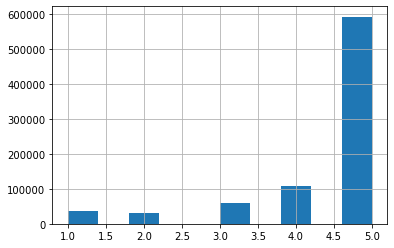

In [173]:
col_info_hist(df.overall)

In [174]:
df['overall']=df['overall'].astype('int32')

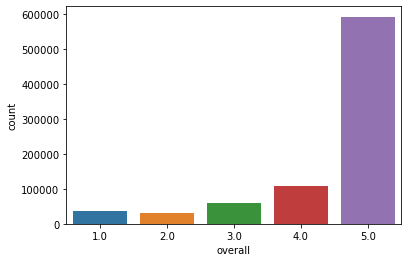

In [175]:
ax = sns.countplot(x="overall", data=train)

## verified

In [176]:
col_info(df.verified)

Количество пропусков: 0,
count     828935
unique         2
top         True
freq      719829
Name: verified, dtype: object,
Распределение:
True     719829
False    109106
Name: verified, dtype: int64,


Данный признак скорее всего означает, что аккаунт пользователя подтвержден. Пропусков нет. Заменим значения на 1 и 0.

In [177]:
dic_verified = {
    True: 1,
    False: 0
}
df['verified'] = df['verified'].map(dic_verified)

Посмотрим распределения рейтинга товаров и оценок товаров 

## reviewTime

In [178]:
col_info(df.reviewTime)

Количество пропусков: 0,
count         828935
unique          4580
top       03 1, 2016
freq             912
Name: reviewTime, dtype: object,
Распределение:
03 1, 2016     912
07 14, 2016    859
06 3, 2015     769
01 20, 2016    764
02 20, 2016    754
              ... 
07 8, 2005       1
08 19, 2006      1
06 28, 2005      1
09 26, 2006      1
06 26, 2006      1
Name: reviewTime, Length: 4580, dtype: int64,


Дата отзыва. Эта информация есть в колонке unixReviewTime в более удобном формате. Удалим данный столбец.

In [179]:
df = df.drop(['reviewTime'], axis=1)

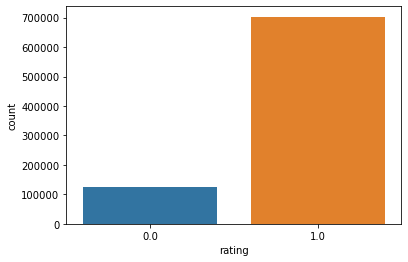

In [180]:
ax = sns.countplot(x="rating", data=train)

## reviewerName

In [181]:
col_info(df.reviewerName)

Количество пропусков: 164,
count              828771
unique             101207
top       Amazon Customer
freq                30667
Name: reviewerName, dtype: object,
Распределение:
Amazon Customer    30667
Kindle Customer     6026
Linda                713
John                 695
David                597
                   ...  
CollegeGrad08          1
Sparkie Howard         1
Hope Hampton           1
kitkate                1
jonilite               1
Name: reviewerName, Length: 101207, dtype: int64,


Видим, что довольно много отзывов с Амазона и Киндла. 180 пропусков. Удалим данный столбец

In [182]:
df = df.drop(['reviewerName'], axis=1)

Видим, что довольно много отзывов с Амазона и Киндла. 180 пропусков. Удалим данный столбец

## reviewText

In [183]:
print('Количество пропусков: {},'.format(df.reviewText.isnull().sum()))

Количество пропусков: 274,


Столбец отсутствует в тестовой выборке. Удалим столбец

In [184]:
df = df.drop(['reviewText'], axis=1)

## summary

In [185]:
df.summary[25]

'Extra Chai'

Столбец отсутствует в тестовой выборке. Удалим столбец

In [186]:
df = df.drop(['summary'], axis=1)

## asin

Идентификатор для модели нам не нужен. Удалим столбец

In [187]:
df = df.drop(['asin'], axis=1)

## unixReviewTime

In [188]:
col_info(df.unixReviewTime)

Количество пропусков: 0,
count    8.289350e+05
mean     1.442160e+09
std      5.973526e+07
min      9.657792e+08
25%      1.412294e+09
50%      1.449619e+09
75%      1.485302e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64,
Распределение:
1456790400    912
1468454400    859
1433289600    769
1453248000    764
1455926400    754
             ... 
1141344000      1
1126742400      1
1151625600      1
1126569600      1
1123113600      1
Name: unixReviewTime, Length: 4580, dtype: int64,


Пропусков нет. Идем дальше

## vote

In [189]:
col_info(df.vote)

Количество пропусков: 712944,
count     115991.0
unique       477.0
top            2.0
freq       30083.0
Name: vote, dtype: float64,
Распределение:
2.0      30083
3.0      15036
2        13464
4.0       8670
3         6806
         ...  
238.0        1
309          1
205          1
229.0        1
152          1
Name: vote, Length: 477, dtype: int64,


Количество пропусков: 728732. Удалим столбец

In [190]:
df = df.drop(['vote'], axis=1)

## style

In [191]:
col_info(df['style'])

Количество пропусков: 399670,
count                      429265
unique                      25892
top       {'Size:': ' Pack of 1'}
freq                         4582
Name: style, dtype: object,
Распределение:
{'Size:': ' Pack of 1'}                                                        4582
{'Package Quantity:': ' 1'}                                                    4470
{'Package Type:': ' Standard Packaging'}                                       3880
{'Size:': ' 1 Pack'}                                                           3707
{'Size:': ' 24 Count'}                                                         3615
                                                                               ... 
{'Size:': ' Pack of 12', 'Flavor:': ' Linguine'}                                  1
{'Size:': ' Case of 1'}                                                           1
{'Size:': ' 4-Pack', 'Flavor:': ' Watermelon Honeydew and Lemon Spearmint'}       1
{'Size:': ' 28oz', 'Style:': ' Crun

Большое количество пропусков. Удалим столбец

In [192]:
df = df.drop(['style'], axis=1)

## image

Ссылки на картинки. Удалим столбец.

In [193]:
df = df.drop(['image'], axis=1)

## userid

In [194]:
col_info(df.userid)

Количество пропусков: 0,
count    828935.000000
mean      54683.270253
std       37012.514250
min           0.000000
25%       21878.000000
50%       49877.000000
75%       85629.000000
max      127495.000000
Name: userid, dtype: float64,
Распределение:
842       421
17987     313
355       297
2024      288
2809      272
         ... 
22381       1
56729       1
90785       1
104926      1
74001       1
Name: userid, Length: 127448, dtype: int64,


id пользователя. Пропусков нет

## itemid

In [195]:
col_info(df.itemid)

Количество пропусков: 0,
count    828935.000000
mean      17461.015157
std       11435.459947
min           0.000000
25%        7127.000000
50%       16514.000000
75%       26928.000000
max       41319.000000
Name: itemid, dtype: float64,
Распределение:
22208    5430
23540    4733
24556    4611
32046    2449
1919     2166
         ... 
39695       1
6577        1
25989       1
6037        1
39004       1
Name: itemid, Length: 41302, dtype: int64,


id товара. Пропусков нет

## rating

In [196]:
col_info(df.rating)

Количество пропусков: 0,
count    828935.000000
mean          0.848275
std           0.358754
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64,
Распределение:
1.0    703165
0.0    125770
Name: rating, dtype: int64,


Целевая переменная. Здесь всего 2 значения - понравился пользователю товар или нет. 

In [197]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


In [198]:
test.head(2)

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1


In [199]:
submission.head(4)

,Id,rating
0,0,0.282813
1,1,0.629758
2,2,0.916899
3,3,0.702790


### Очистка и подготовка данных

In [200]:
# Удалим в Train ненужные столбцы
train = train.drop(['verified', 'reviewTime', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'style', 'image'], axis=1)

In [201]:
# посмотрим число пропущенных значений в train
train.isnull().sum()

overall         0
asin            0
vote       712944
userid          0
itemid          0
rating          0
dtype: int64

In [202]:
train.head(2)

,overall,asin,vote,userid,itemid,rating
0,5.0,B01CPNIEQG,NaN,102179,37138,1.0
1,5.0,B006F63M8U,NaN,3625,17322,1.0


In [203]:
# Удалим в test ненужные столбцы
test = test.drop(['verified', 'reviewTime', 'vote', 'reviewerName', 'unixReviewTime', 'style', 'image'], axis=1)
test

,asin,userid,itemid,Id
0,B001E5E3X0,68877,7506,0
1,B005BYXX5E,50442,15530,1
2,B0052OK6OO,64349,15049,2
3,B003SO8HGE,26206,11957,3
4,B003XUJ564,59366,12173,4
...,...,...,...,...
285960,B00FLD3X28,294,25601,285960
285961,B0078DQ85S,119653,18204,285961
285962,B000FZVLFS,54673,2287,285962
285963,B001PB801Y,16569,9343,285963


In [204]:
#посмотрим число пропущенных значений в test
test.isnull().sum()

asin      0
userid    0
itemid    0
Id        0
dtype: int64

> Видим, что есть случаи, когда вместо наименования, в соответствующем поле встречается техническая информация. Посмотрим сколько таких случаев было:

In [205]:
test.head(2)

,asin,userid,itemid,Id
0,B001E5E3X0,68877,7506,0
1,B005BYXX5E,50442,15530,1


In [206]:
test.isnull().sum()

asin      0
userid    0
itemid    0
Id        0
dtype: int64

Чтобы работать с моделями в библиотеке LightFm, нам нужно создать разреженные матрицы. Мы будем хранить данные в формате COO (координатный формат представления данных). Вместо хранения всех значений, которые включают нулевые значения, мы будем хранить только ненулевые значения. В COO данные представлены в виде (строка, столбец, значение).

Формируем разреженную матрицу

ratings_coo: размером train_data.userid(row) * train_data.itemid(col), с соответствующим значением рейтинга товара train_data.rating в полях

### Предсказания без использования фичей

In [207]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
import scipy.sparse as sparse

In [208]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [209]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621701 entries, 728049 to 10972
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   overall  621701 non-null  float64
 1   asin     621701 non-null  object 
 2   vote     86973 non-null   object 
 3   userid   621701 non-null  int64  
 4   itemid   621701 non-null  int64  
 5   rating   621701 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 33.2+ MB


In [210]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))
#Разбиваем наш датасет на обучающую и тестовую выборки
#ratings_coo_train,ratings_coo_test = random_train_test_split(ratings_coo, test_percentage=0.2, random_state=32)

### Models

In [211]:
LR = 0.089
NUM_THREADS = 8 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 20

model = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model = model.fit(
    ratings_coo,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

In [212]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

Посчитаем метрику roc_auc_score

In [213]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.728837458951924

В качестве эксперимента создадим ещё одну модель, которую обучим на всем тренировочном датасете

In [214]:
# Создадим разреженную матрицу
ratings_coo2 = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],
                                  train['itemid'],)))

# Обучим модель
model2 = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE
)
model2 = model.fit(
    ratings_coo2,
    epochs=NUM_EPOCHS,
    num_threads=NUM_THREADS
)

## Предсказание на тестовом датасете

In [215]:
preds = model.predict(test.userid.values,
                      test.itemid.values)
preds2 = model2.predict(test.userid.values,
                      test.itemid.values)

Нормализуем предсказания

In [216]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds2 = (preds2 - preds2.min())/(preds2 - preds2.min()).max()

## Submission

In [217]:
submission['rating']= normalized_preds
submission.to_csv('submission_1.csv', index=False)

In [218]:
submission['rating']= normalized_preds2
submission.to_csv('submission_full.csv', index=False)

## Итоги работы

В результате работы был произведен анализ данных. Добавление новых фичей не увеличило итоговый рейтинг, поэтому в данной работе был использован основной набор признаков из датасета train. Были определены пропуски и удалены ненужные признаки. Был получен результат метрики roc_auc 0.767 на полном наборе данных train без разбивки на обучающую и тестовую выборки. Общим итогом работы является знакомство с основами рейтинговых систем